In [1]:
from barney_functions import add_labels_to_excel,gen_audio_array,buffer,shifter,louder,plot_mel,augment_audio,plot_sample,hsr_loader,lsr_loader,calc_stft,calc_melstft,spec_plot, gen_labels, gen_audio_array_noexcel,augment_audio_faster

In [2]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import os
from tqdm import tqdm 

In [4]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
audio_files, index_longest = hsr_loader(audio_path,df)
audio_files_long, _, filenames_long, longest_file = gen_audio_array_noexcel(audio_path_long)
labels = df['label']
labels_long = gen_labels(filenames_long)

Adding labels


100%|█████████████████████████████████████| 413/413 [00:00<00:00, 503706.76it/s]


Finding longest file (Worse Labels)


100%|███████████████████████████████████████| 413/413 [00:00<00:00, 3137.46it/s]


Finding longest file (Worse Labels)


100%|███████████████████████████████████████| 1719/1719 [01:09<00:00, 24.69it/s]


Loading files


100%|███████████████████████████████████████| 1719/1719 [01:06<00:00, 25.71it/s]


In [5]:
augmented_audio = augment_audio(audio_files)
#augmented_audio_long = augment_audio(audio_files_long)
augmented_audio_long_fast = augment_audio_faster(audio_files_long)

Augmenting Non-noise


100%|█████████████████████████████████████████| 413/413 [00:06<00:00, 68.61it/s]


Making noise


100%|█████████████████████████████████████████| 413/413 [00:39<00:00, 10.35it/s]


Augmenting


100%|███████████████████████████████████████| 1719/1719 [00:22<00:00, 76.81it/s]


In [6]:
augmented_audio.shape

(5, 413, 511008)

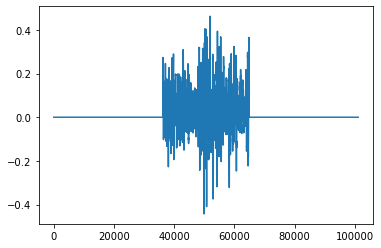

In [7]:
plt.plot(audio_files_long[400])

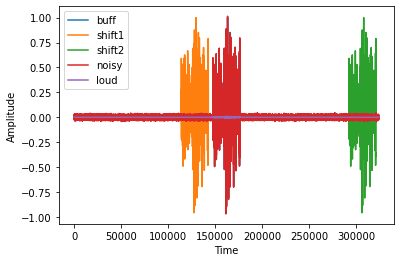

In [8]:
plot_sample(augmented_audio_long_fast,400)

In [ ]:
#stfts = calc_stft(augmented_audio)
#stfts_long = calc_stft(augmented_audio_long)
stfts_long_fast = calc_stft(augmented_audio_long_fast)
#mels = calc_melstft(augmented_audio)

Augmentation  1


100%|███████████████████████████████████████| 1719/1719 [00:36<00:00, 46.75it/s]


Augmentation  2


100%|███████████████████████████████████████| 1719/1719 [00:38<00:00, 45.02it/s]


Augmentation  3


 19%|███████▍                                | 319/1719 [00:07<00:30, 46.12it/s]

In [ ]:
stfts_long_fast.shape

In [ ]:
spec_plot(stfts_long_fast[4,400,:,:])

In [ ]:
#np.save('stfts_array',stfts)
#np.save('stfts_array_long',stfts)

In [ ]:
#stfts = np.load('stfts_array.npy')
#stfts_long = np.load('stfts_array_long.npy')